# `NoEpistasisGaussianLikelihood` model
Simulates some variants and analyzes them under the `globalepistasis.NoEpistasisGaussianLikelihood` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import copy
import math
import random
import time
import warnings

import numpy

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 25  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 25 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATC


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

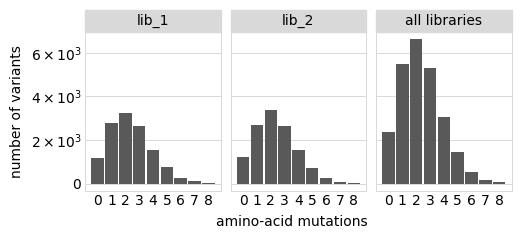

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    norm_weights=((0.4, -0.5, 0.7), (0.6, -5, 1.5)),
                    stop_effect=-9,
                    )

But since we are using a non-epistatic (linear model), we will simulate variants according to the *latent phenotype* rather than their *observed phenotype* (since in a non-epistatic model these two are the same).
First, look at the distribution of latent phenotypes for all single mutants (the dashed orange line is the latent phenotype of wildtype):

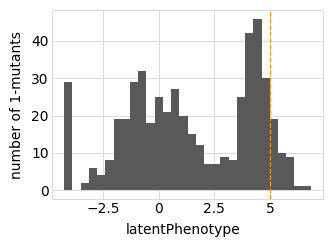

In [10]:
p = phenosimulator.plotMutsHistogram('latentPhenotype')
_ = p.draw()

Our simulation function is then the exponential of the latent phenotype, as mutants as the functional scores represent the log enrichment:

In [11]:
def phenotype_func(x):
    return math.exp(phenosimulator.latentPhenotype(x))

Now we simulate the counts, passing to the simulate function the latent rather than observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenotype_func,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

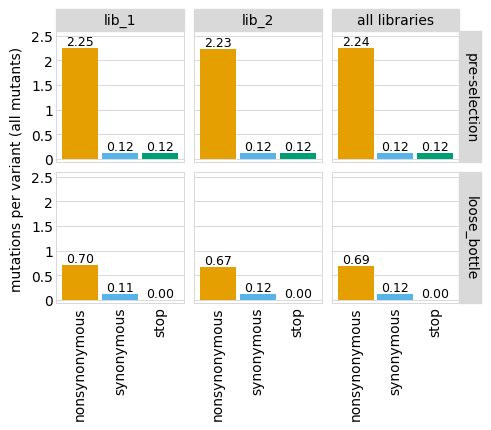

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,28133593,12500000,2.250687
1,lib_1,pre-selection,synonymous,1516864,12500000,0.121349
2,lib_1,pre-selection,stop,1465269,12500000,0.117222
3,lib_1,loose_bottle,nonsynonymous,8745167,12500000,0.699613
4,lib_1,loose_bottle,synonymous,1385003,12500000,0.110800
5,lib_1,loose_bottle,stop,170,12500000,0.000014
6,lib_2,pre-selection,nonsynonymous,27899970,12500000,2.231998
7,lib_2,pre-selection,synonymous,1507947,12500000,0.120636
8,lib_2,pre-selection,stop,1474547,12500000,0.117964
9,lib_2,loose_bottle,nonsynonymous,8403904,12500000,0.672312


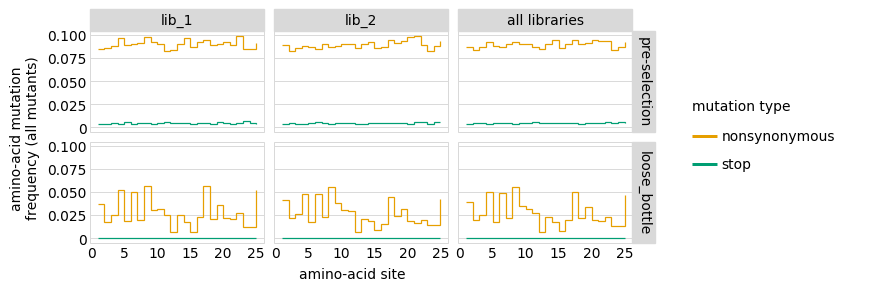

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

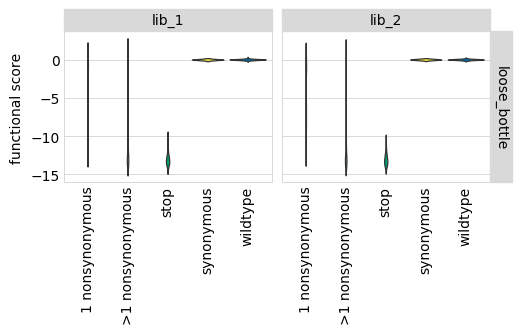

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 500


Now initialize the `NoEpistasisGaussianLikelihood` model:

In [21]:
model = dms_variants.globalepistasis.NoEpistasisGaussianLikelihood(binarymap)

Look at some model attributes:

In [22]:
model.nparams

502

In [23]:
model.likelihood_calc_params_dict['epistasis_HOC']

1.0

In [24]:
round(model.loglik)

-447718

In [25]:
model.latent_phenotype_wt()

0.0

Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [26]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Initial least squares fitting
Perform initial least squares optimization (normally this is actually performed by the `fit` method):

In [27]:
model._fit_latent_leastsquares()

Re-check the gradients:

In [28]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

In [29]:
round(model.loglik)

-60249

In [30]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
        )
print(f"R = {r:.3f}, P = {p:.2g}")

R = 0.837, P = 0


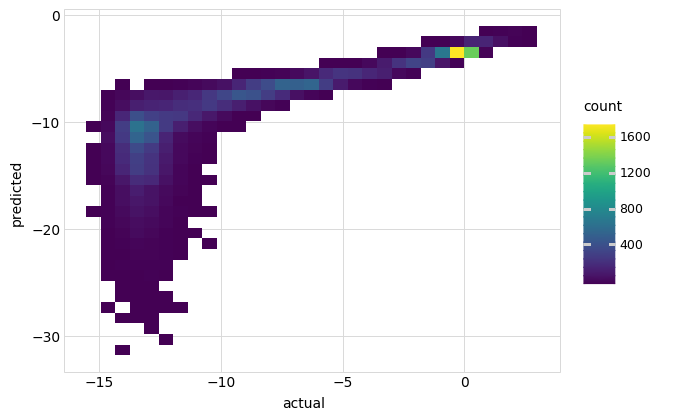

In [31]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()

In [32]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

epistasis_HOC: 5.816


In [33]:
round(model.latent_phenotype_wt(), 3)

-3.203

## Fit the full model

Now fit the model by maximum likelihood.


In [34]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
optres = model.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")

Fitting took 0.105 seconds


In [35]:
round(model.loglik)

-59809

In [36]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

epistasis_HOC: 4.837


In [37]:
round(model.latent_phenotype_wt(), 3)

-2.49

In [38]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
        )
print(f"R = {r:.3f}, P = {p:.2g}")

R = 0.837, P = 0


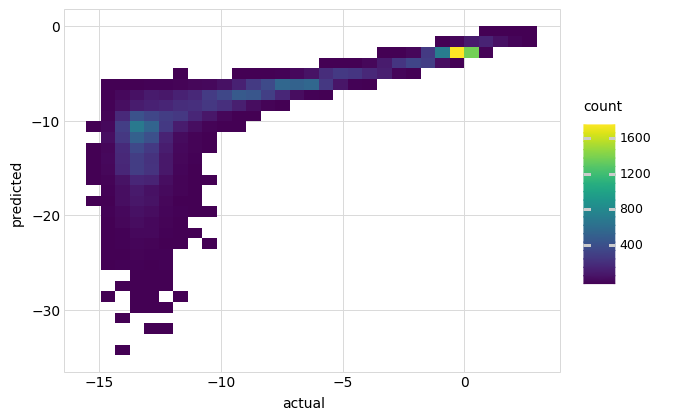

In [39]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (
     ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()

## Fit model with **two** latent phenotypes
Initialize model with 2 latent phenotypes, using the prior 1-latent phenotype model.
Note that for a non-epistatic model, a multi-latent model should be identical to a single-latent model, so some of the tests below will confirm that:

In [40]:
model2 = dms_variants.globalepistasis.NoEpistasisGaussianLikelihood(
                binarymap=binarymap,
                n_latent_phenotypes=2,
                model_one_less_latent=model)

Number of parameters:

In [41]:
model2.nparams

1003

Some initial parameters:

In [42]:
round(model2.likelihood_calc_params_dict['epistasis_HOC'], 2)

4.84

In [43]:
round(model2.loglik)

-59809

In [44]:
for k in range(1, model2.n_latent_phenotypes + 1):
    print(k, round(model2.latent_phenotype_wt(k=k), 2))

1 -2.49
2 0.0


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient.
In the test below, we're actually pretty tolerant since the model is at the max so the total gradient will be small:

In [45]:
err = scipy.optimize.check_grad(
            model2._loglik_by_allparams,
            model2._dloglik_by_allparams,
            model2._allparams)
tot = math.sqrt(sum(model2._dloglik_by_allparams(model2._allparams)**2))
if err / tot > 1e-1:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Now re-test the gradients with a more stringent tolerance after "un-fitting" the model away from the maximum:

In [46]:
unfit_model2 = copy.deepcopy(model2)
unfit_model2._latenteffects = numpy.zeros(unfit_model2._latenteffects.shape)

err = scipy.optimize.check_grad(
            unfit_model2._loglik_by_allparams,
            unfit_model2._dloglik_by_allparams,
            unfit_model2._allparams)
tot = math.sqrt(sum(unfit_model2._dloglik_by_allparams(unfit_model2._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Fit the model by maximum likelihood:

In [47]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
optres = model2.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")

Fitting took 0.016 seconds


For a non-epistatic model, the multi-latent phenotype model should be the same as the single latent phenotype in terms of likelihood:

In [48]:
if not numpy.allclose(model.loglik, model2.loglik, atol=0.1):
    raise ValueError(f"log likelihoods differ: {model.loglik} vs {model2.loglik}")

The one-latent phenotype wildtype latent should be the same as the sum of the latent phenotypes of multi-latent model:

In [49]:
if not numpy.allclose(model.latent_phenotype_wt(),
                      sum(model2.latent_phenotype_wt(k) for k in range(1, model2.n_latent_phenotypes + 1)),
                      atol=0.1
                      ):
    raise ValueError("wt latent phenotypes differ")

There are no epistasis function parameters for a no-epistasis model:

In [50]:
model2.epistasis_func_params_dict

{}

The likelihood calculation parameters:

In [51]:
assert scipy.allclose(model2.likelihood_calc_params_dict['epistasis_HOC'], 4.84, atol=0.05), model2.likelihood_calc_params_dict

The number of latent effects should be twice the number of mutations:

In [52]:
# NBVAL_IGNORE_OUTPUT
model2.latent_effects_df.head()

,mutation,latent_effect,latent_phenotype_number
0,R1*,-4.167662,1
1,R1A,0.173918,1
2,R1C,-1.183262,1
3,R1D,-4.572701,1
4,R1E,-3.082266,1


In [53]:
if model2.latent_effects_df.shape != (genelength * 20 * model2.n_latent_phenotypes, 3):
    raise ValueError(f"unexpected shape for latent effects")

For a no-epistasis model, the sum at a site of latent effects for a multi-latent phenotype model should equal the latent effects for a single-latent phenotype model:

In [54]:
(model2.latent_effects_df
 .groupby('mutation')
 .aggregate(multi_latent_sum=pd.NamedAgg('latent_effect', 'sum'))
 .reset_index()
 .merge(model.latent_effects_df, on='mutation')
 .assign(nearly_equal=lambda x: abs(x['multi_latent_sum'] - x['latent_effect']) < 5e-2)
 ['nearly_equal']
 .all()
 )

True

Look at the phenotypes; there should be one for each latent phenotype:

In [55]:
# NBVAL_IGNORE_OUTPUT
model2.phenotypes_df.head()

,aa_substitutions,func_score,func_score_var,latent_phenotype_1,latent_phenotype_2,observed_phenotype
0,,0.023237,0.000643,-2.490396,-0.000116,-2.490512
1,S11C N20G P24A,-15.140211,4.163345,-10.170586,-0.000100,-10.170686
2,R1P L18N,-5.984570,0.007924,-6.582197,-0.000184,-6.582381
3,I4A,-5.900341,0.007905,-5.391154,-0.000187,-5.391341
4,L5G Y8R R15N L23Q,-15.038653,4.163389,-15.777580,-0.000174,-15.777754


In [56]:
model2.phenotypes_df.columns.tolist()

['aa_substitutions',
 'func_score',
 'func_score_var',
 'latent_phenotype_1',
 'latent_phenotype_2',
 'observed_phenotype']

The observed phenotypes should be essentially the same for the one- and two-latent phenotype models:

In [57]:
(model2.phenotypes_df
 .rename(columns={'observed_phenotype': 'multi_latent_observed_phenotype'})
 .merge(model.phenotypes_df)
  .assign(nearly_equal=lambda x: abs(x['multi_latent_observed_phenotype'] - x['observed_phenotype']) < 5e-2)
 ['nearly_equal']
 .all()
 )

True

In [58]:
# NBVAL_IGNORE_OUTPUT
for k in range(1, model2.n_latent_phenotypes + 1):
    print(model2.single_mut_effects(phenotype='latent', k=k).head().round(2))

  mutation wildtype  site mutant  effect
0      V3*        V     3      *   -2.31
1      S2Y        S     2      Y   -2.26
2      R6W        R     6      W   -2.15
3      L5*        L     5      *   -2.12
4     N20*        N    20      *   -2.08
  mutation wildtype  site mutant  effect
0     S11M        S    11      M   -7.76
1     R12M        R    12      M   -7.60
2     C19W        C    19      W   -6.30
3     D22W        D    22      W   -4.88
4     L18G        L    18      G   -3.76
